# Pythonradex
Re-implementation of the RADEX code.
Adventages of pythonradex:
- faster
- provides a convenient method to read files from the LAMDA database, official website: https://home.strw.leidenuniv.nl/~moldata/.
- provides additional functionality that is not included in RADEX (treatment of overlapping lines)
- RADEX calculates the flux for all geometries using the equation which is only valid for slab geometry, pythonradex uses the correct formulae for spherical geometries.



In [1]:
import pythonradex

# # import necessary modules
from pythonradex import radiative_transfer, helpers, LAMDA_file
from scipy import constants
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

from IPython.display import display, HTML


In [2]:
print(dir(pythonradex))

['LAMDA_file', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'atomic_transition', 'escape_probability', 'escape_probability_functions', 'flux', 'helpers', 'molecule', 'radiative_transfer', 'rate_equations']


# Getting started with pythonradex

- Radiative transfer calculation is conducted using the Cloud class which is provided by the radiative_transfer module
- Possible geometries: "Gaussian",  “rectangular”, "LVG sphere", "LVG slab”
- For LVG geometries the parameter "line_profile_type" needs to be set to “rectangular”. This ensures that the optical depth is calculated correctly.


In [3]:
# pyhonradex needs a file containing the atomic data, import it, this is a specific file for CO from LAMBDA database
datafilepath = r"C:\Users\alios\OneDrive - University College London\Desktop\UCL\Year3\group project\codes\co_datafile.dat"  # file downloaded from LAMDA database


# define the geometry of the nebula
geometry = "uniform sphere"

# define the parameters of the nebula
line_profile_type = "Gaussian"  # line profile, can be "Gaussian",  “rectangular”,"LVG sphere", "LVG slab”
width_v = 5 * constants.kilo  # line width in m/s, costants.kilo is 1 km/s

cloud = radiative_transfer.Cloud(
    datafilepath=datafilepath,
    geometry=geometry,
    line_profile_type=line_profile_type,
    width_v=width_v,
)

## line width parameter "width_v" explained
- There are different interpretations of the input parameter width_v used by pythonradex
-  For static geometries, this refers to the local emission width, two kinds of local emission profiles:

   - "Gaussian" in which case width_v refers to the FWHM
   - "rectangular" in which case width_v refers to the FWHM
- For the LVG geometries (“LVG sphere” and “LVG slab”), width_v refers to the global velocity width of the cloud

## Set the parameters characterising the cloud physical conditions.
- use update_parameters method to do this.


In [4]:
## possible atributes of the cloud object

# update_parameters
# solve_radiative_transfer()
# fluxes_of_individual_transitions(solid_angle, transitions)

In [5]:
N = 1e18 / constants.centi**2  # CO column density in m-2
Tkin = 30  # kinetic temperature in [K]

# collider densities in cm-3:
para_h2_density = 1e8
ortho_h2_density = 3e8

# collider densities in m-3 (phytonradex takes the densities in m-3):
collider_densities_LTE = {
    "para-H2": para_h2_density / constants.centi**3,
    "ortho-H2": ortho_h2_density / constants.centi**3,
}

# define the background radiation field, in this case we assume that the background is zero, z is the redshift
ext_background = helpers.generate_CMB_background(z=0)

# no dust:
T_dust = 0
tau_dust = 0

# use high colliders density to simulate LTE
cloud.update_parameters(
    N=N,
    Tkin=Tkin,
    collider_densities=collider_densities_LTE,
    ext_background=ext_background,
    T_dust=T_dust,
    tau_dust=tau_dust,
)

# solve the radiative trasfer equation, i.e. calculate the level population with an iterative method
cloud.solve_radiative_transfer()

# Format in which data is stored in LAMDA

Further informations in: https://doi.org/10.48550/arXiv.2004.11230
### ENERGY LEVELS section
!LEVEL + ENERGIES(cm^-1) + WEIGHT + J 
- level number (starting with 1)
- level energy (cm−1) 
- statistical weight.
- level quantum number J for CO, J_k for methanol

The levels are  listed in order of increasing energy.

### RADIATIVE TRANSITIONS section
!TRANS + UP + LOW + EINSTEINA(s^-1) + FREQ(GHz) + E_u(K)
- transition number (starting with 1), which is informative for human readers
- upper level indices given in the Energy Levels Section
- lower level indices given in the Energy Levels Section
- Einstein A-coefficient, spontaneous decay rate (s⁻¹)
- rest frequencies (GHz) not in spectroscopic accuracy, not read by radiative transfer programs, informative for human readers
- upper level energies (K)



# Format in which data is returned by print_results
  up  | low   |   nu0 [GHz]  |  T_ex [K]   |   poplow      |   popup    |     tau_nu0
- upper level indices given in the Energy Levels Section, the numering is started from 0, so all the transitions are -1 compared to what is stored in LAMDA
- lower level indices given in the Energy Levels Section, the numering is started from 0, so all the transitions are -1 compared to what is stored in LAMDA
- rest frequencies (GHz) computed from the level energies given in the file
- Exitation temperature in (K)
- poplow: Fractional population of lower level (computed by taking in consideration escape probability)
- poplow: Fractional population of upper level (computed by taking in consideration escape probability)
- tau_nu0: optical depth of each transition

In [6]:
# print the results
cloud.print_results()



  up   low      nu0 [GHz]    T_ex [K]      poplow         popup         tau_nu0
   1    0     115.271202      30.00      0.0893981        0.22303        4.27824
   2    1     230.538000      30.00        0.22303       0.257065        13.0242
   3    2     345.795990      30.00       0.257065       0.206978        18.6005
   4    3     461.040768      30.00       0.206978       0.127278        17.4816
   5    4     576.267931      30.00       0.127278      0.0618778        12.0401
   6    5     691.473076      30.00      0.0618778      0.0241917        6.37136
   7    6     806.651806      30.00      0.0241917     0.00767975        2.65716
   8    7     921.799700      30.00     0.00767975     0.00199146       0.886205
   9    8    1036.912393      29.99     0.00199146    0.000423549       0.238672
  10    9    1151.985452      29.99    0.000423549    7.40961e-05      0.0522293
  11   10    1267.014486      29.99    7.40961e-05    1.06841e-05     0.00934442
  12   11    1381.995105   

## How fractional population is defined:

Column density of the upper state $N_u$
Fractional population of the upper  level  $n_u$ is the proportion of particles in the upper state relative to the total population of the species ($N_{tot}$):
$$n_u = \frac{N_u}{N_{tot}}$$

# TO DO LIST
- FIX gu values and g_weigths <span style="color: green;">Done</span>
- implement gup from testing file  <span style="color: green;">Done</span>
- remove levels = self.data_of_molecule["levels"] from method   <span style="color: green;">Done</span>
- compare cloud.emitting_molecule.LTE_level_pop(T=new_Tkin) with cloud.level_pop 
- implement get_transition_populations      <span style="color: green;">Done</span>
- fix population diagram for nonLTE CO  <span style="color: green;">Done</span>
- fix gamma*W/gu plot => gamma is not flux but integrated line intensity

# Functions:  Values extraction and gamma/tau calculator

In [7]:
class MyClass:
    def __init__(self, cloud_name, data_of_molecule, column_density_species, width_v, Tkin):
        """
        Initialize the class with the cloud object, the data of the molecule, the column density of the species, the width of the line and the kinetic temperature.

        Parameters
        ----------
        cloud_name : pythonradex.Cloud
            The cloud object.
        data_of_molecule : dict
            The data of the molecule.
        column_density_species : float
            The column density of the species in m^2.
        width_v : float
            The width of the line in m/s
        Tkin : float
            The kinetic temperature in [K].
        """
        self.cloud_name = cloud_name
        self.data_of_molecule = data_of_molecule
        self.column_density_species = column_density_species
        self.width_v = width_v
        self.Tkin = Tkin
        self.extract_and_calculate()  # this allows optical_depth to use the extracted values from the extract_and_calculate method

    def get_transition_populations(self, names_transitions):
        """
        Relates all the transitions in names_transitions with their corresponding population densities.

        Parameters
        ----------
        names_transitions: (list of str):
            List of transitions in the format ['79-78', '14-13', ...], where each element is a string with the format "upper_level-lower_level".

        Returns
        -------
            tuple: Two arrays, one for upper and one for lower populations density.
        """
        upper_populations = []
        lower_populations = []
        for transition in names_transitions:
            upper_level, lower_level = map(int, transition.split("-"))  # split the string and convert to integers
            upper_pop = self.cloud_name.level_pop[upper_level]
            lower_pop = self.cloud_name.level_pop[lower_level]
            upper_populations.append(upper_pop)
            lower_populations.append(lower_pop)

        nu = np.array(upper_populations)
        nl = np.array(lower_populations)
        # compute upper level population density, given by: fractional population density x total column density
        Nu = nu * self.column_density_species
        Nl = nl * self.column_density_species
        return Nu, Nl

    def extract_and_calculate(self, debug=False):
        """
        Extract values from the cloud object and the data file, and calculate gamma factor

        Parameters
        ----------
        debug : boolean, optional
            If True, print debugging information. Default is False.

        Returns
        --------
        Tex: np.array
            The excitation temperature of the molecule.
        tau: np.array
            The optical depth of the transitions.
        Aul : np.array
            The Einstein coefficient for spontaneous emission [s^-1].
        Bul : np.array
            The Einstein coefficient for stimulated emission in [sr m2 Hz / Jy].
        nu0_array : np.array
            The rest frequency of the transition in Hz.
        Eu : np.array
            The energy of the upper level in [K].
        gu : np.array
            The statistical weight of the upper level.
        gamma: np.array
            Gamma factors, which is calculated using: gamma = (8 * np.pi * k * nu0**2) / (h * c**3 * Aul)
        Nu: np.array
            Upper level population density in [m-2].
        Nl: np.array
            Lower level population density in [m-2].
        FWHM_each_transition: np.array
            Frequency width of each transition in [Hz].
        """
        # Extract values
        self.Tex = self.cloud_name.Tex
        self.Aul = self.cloud_name.emitting_molecule.A21
        self.Bul = self.cloud_name.emitting_molecule.B21
        self.nu0_array = self.cloud_name.emitting_molecule.nu0
        self.tau = self.cloud_name.tau_nu(self.nu0_array)

        # levels = self.data_of_molecule["levels"]
        rad_transitions = self.data_of_molecule["radiative transitions"]

        # Extract upper energy levels in [J] and convert to Kelvin
        self.Eu = np.array([transition.up.E for transition in rad_transitions]) / constants.k

        # Get the statistical weight of the upper and lower levels
        self.gu = np.array([transition.up.g for transition in rad_transitions])
        self.glow = np.array([transition.low.g for transition in rad_transitions])

        # Get names of transitions
        names_transitions = np.array([tran.name for tran in rad_transitions])

        # Compute upper and lower level population densities
        self.Nu, self.Nl = self.get_transition_populations(names_transitions)

        # Convert velocity width to frequency width
        self.FWHM_each_transition = self.nu0_array * (self.width_v / constants.c)

        # Calculate gamma factor
        self.gamma = (8 * np.pi * constants.k * self.nu0_array**2) / (constants.h * constants.c**3 * self.Aul)

        if debug:
            # Debugging print statements
            print("Size of nu0_array:", len(self.nu0_array))
            print("Size of Eu:", len(self.Eu))
            print("E upper levels:", self.Eu)
            print("Size of gu:", len(self.gu))
            print("size exitation temperature Tex:", len(self.Tex))
            print(" gu:", self.gu)
            print("Size of glow:", len(self.glow))
            print(" glow:", self.glow)
            print("size Aul:", len(self.Aul))
            print("size FWHM_each_transition:", len(self.FWHM_each_transition))
            print("size gamma:", len(self.gamma))
            print("size Nu:", len(self.Nu))
            print("size Nl:", len(self.Nl))

        return (
            self.Tex,
            self.tau,
            self.Aul,
            self.Bul,
            self.nu0_array,
            self.Eu,
            self.gu,
            self.glow,
            self.gamma,
            self.Nu,
            self.Nl,
            self.FWHM_each_transition,
        )

    def optical_depth(self):
        """
        Calculate the optical depth of a transition using the different approaches.
        In both method the change of optical depth over the line profile is not taken into account

        Returns
        -------
        tau_with_correction_factor : np.array
            Optical depth computed with the correction factor for gaussian line profile function.
        tau_without_correction_factor : np.array
            Optical depth computed without the correction factor for gaussian line profile function.

        """
        # Ensure extract_and_calculate has been called,
        if not hasattr(self, "Tex"):  # checks if the instance variable Tex has already been set, returns True if the object already has an attribute.
            self.extract_and_calculate()

        conversion_factor = np.sqrt(np.pi) / (2 * np.sqrt(np.log(2)))  ## approx. 1.0645
        # Equation used in RADEX, with correction factor for gaussian line profile function
        tau_with_correction_factor = (
            (constants.c**2 / (8 * np.pi * self.nu0_array**2))
            * self.Aul
            * ((self.Nl * self.gu / self.glow) - self.Nu)
            / (conversion_factor * self.FWHM_each_transition)
        )
        # Equation used in RADEX, without correction factor for gaussian line profile function
        tau_without_correction_factor = (
            (constants.c**2 / (8 * np.pi * self.nu0_array**2)) * self.Aul * ((self.Nl * self.gu / self.glow) - self.Nu) / self.FWHM_each_transition
        )

        return tau_with_correction_factor, tau_without_correction_factor

# Read file from the LAMDA database

In [8]:
# store the data
data_co = LAMDA_file.read(datafilepath, read_frequencies=True)
# LAMDA_file returns a dictionary containing the data read from the file.

# Full list of attributes
print(data_co.keys())

dict_keys(['levels', 'radiative transitions', 'collisional transitions', 'quantum numbers'])


In [9]:
conversion_factor = np.sqrt(np.pi) / (2 * np.sqrt(np.log(2)))
conversion_factor

np.float64(1.0644670194312262)

In [10]:
# Relationship between FWHM and sigma for a Gaussian
fwhm_to_sigma = 2 * np.sqrt(2 * np.log(2))  # ≈ 2.355

# Compute the correction factor (1 / (sqrt(2π) * sigma))
correction_factor = 1 / (np.sqrt(2 * np.pi) * (fwhm_to_sigma))

print(f"Calculated correction factor: {correction_factor:.6f}")

Calculated correction factor: 0.169415


In [11]:
# Create an instance of myclass
CO_cloud_instance = MyClass(cloud, data_co, N, width_v, Tkin)

# Extract values from the cloud object and the data file, and calculate gamma factor
TexCo, tauCo, AulCo, BulCo, nu0_arrayCo, EuCo, gCO, gCOlow, gammaCo, NuCo, NlCo, FWHMCO = CO_cloud_instance.extract_and_calculate(debug=True)

Size of nu0_array: 40
Size of Eu: 40
E upper levels: [   5.53214517   16.59617609   33.19188137   55.31833031   82.974736
  116.16031175  154.87340764  199.11280441  248.87685379  304.16332873
  364.97043585  431.29580629  503.13678297  580.49056589  663.35449669
  751.72520052  845.599158    944.97313597 1049.84303913 1160.20491752
 1276.0546769  1397.3877882  1524.19972692 1656.48539072 1794.2399659
 1937.45806361 2086.1342947  2240.26298185 2399.83801775 2564.8534387
 2735.3029919  2911.18013782 3092.47804981 3279.18990371 3471.30844029
 3668.82625666 3871.73609478 4080.02983772 4293.69964515 4512.73740391]
Size of gu: 40
size exitation temperature Tex: 40
 gu: [ 3.  5.  7.  9. 11. 13. 15. 17. 19. 21. 23. 25. 27. 29. 31. 33. 35. 37.
 39. 41. 43. 45. 47. 49. 51. 53. 55. 57. 59. 61. 63. 65. 67. 69. 71. 73.
 75. 77. 79. 81.]
Size of glow: 40
 glow: [ 1.  3.  5.  7.  9. 11. 13. 15. 17. 19. 21. 23. 25. 27. 29. 31. 33. 35.
 37. 39. 41. 43. 45. 47. 49. 51. 53. 55. 57. 59. 61. 63. 65. 67. 6

In [12]:
# Calculate the optical depth of a transition using the different approaches
tau_radex, tau_radex_without_correction = CO_cloud_instance.optical_depth()

In [13]:
NUM_TRANSITIONS = 15

# Slice the arrays to get only the first NUM_TRANSITIONS transitions
TexCo = TexCo[:NUM_TRANSITIONS]
tauCo = tauCo[:NUM_TRANSITIONS]
AulCo = AulCo[:NUM_TRANSITIONS]
BulCo = BulCo[:NUM_TRANSITIONS]
nu0_arrayCo = nu0_arrayCo[:NUM_TRANSITIONS]
EuCo = EuCo[:NUM_TRANSITIONS]
gCO = gCO[:NUM_TRANSITIONS]
gammaCo = gammaCo[:NUM_TRANSITIONS]
NuCo = NuCo[:NUM_TRANSITIONS]

# Slice tau arrays
tau_radex = tau_radex[:NUM_TRANSITIONS]
tau_radex_without_correction = tau_radex_without_correction[:NUM_TRANSITIONS]

In [14]:
# compute the flux from the cloud
distance_observer = 100 * constants.parsec  # distance between the observer and the cloud in m
source_radius = 10 * constants.au  # radius of the source in m
# solid angle of the source
source_solid_angle = source_radius**2 * np.pi / distance_observer**2

fluxCo = cloud.fluxes_of_individual_transitions(transitions=None, solid_angle=source_solid_angle)
# get the flux of the first NUM_TRANSITIONS transitions
fluxCo = fluxCo[:NUM_TRANSITIONS]

# Optical depth investigation

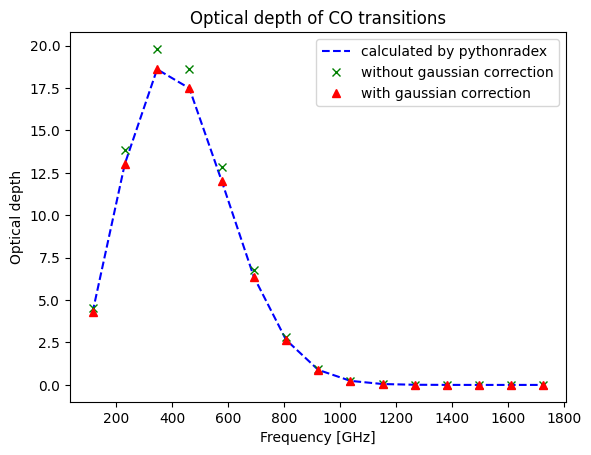

In [18]:
# plot the optical depth
plt.title("Optical depth of CO transitions")
plt.plot(nu0_arrayCo / constants.giga, tauCo, "--", label="calculated by pythonradex", color="blue")
plt.plot(nu0_arrayCo / constants.giga, tau_radex_without_correction, "x", label="without gaussian correction", color="green")
plt.plot(nu0_arrayCo / constants.giga, tau_radex, "^", label="with gaussian correction", color="red")

plt.xlabel("Frequency [GHz]")
plt.ylabel("Optical depth")
plt.legend()
plt.show()

In [19]:
(tauCo - tau_radex) * 100

array([ 8.88178420e-14, -7.10542736e-13,  7.10542736e-13,  0.00000000e+00,
        3.55271368e-13,  8.88178420e-14,  4.44089210e-14,  2.22044605e-14,
       -5.55111512e-15,  6.93889390e-16,  1.73472348e-16,  4.33680869e-17,
        1.08420217e-17,  6.77626358e-19, -2.11758237e-20])

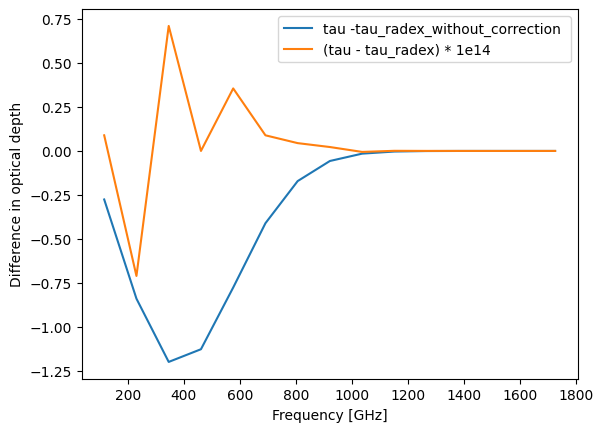

In [20]:
# plot the difference between the two methods
plt.plot(nu0_arrayCo / constants.giga, (tauCo - tau_radex_without_correction), label="tau -tau_radex_without_correction ")
plt.plot(nu0_arrayCo / constants.giga, (tauCo - tau_radex) * 1e14, label="(tau - tau_radex) * 1e14")
plt.xlabel("Frequency [GHz]")
plt.ylabel("Difference in optical depth")
plt.legend()
plt.show()

# Population diagram fo CO, LTE case

according to goldsmith and lander: $N_u =\gamma W /\beta $

In [21]:
# Calculate gamma * flux and compare with Nu
gamma_flux = gammaCo * fluxCo
print("gamma * flux (first 5):", gamma_flux[:5])
print("Nu (first 5):", NuCo[:5])
print("Are gamma * flux and Nu the same?", np.allclose(gamma_flux, NuCo))

gamma * flux (first 5): [7.60140386e-07 3.23141705e-06 6.60997852e-06 1.01297548e-05
 1.29117491e-05]
Nu (first 5): [2.23030007e+21 2.57065402e+21 2.06977854e+21 1.27278291e+21
 6.18777563e+20]
Are gamma * flux and Nu the same? False


In [22]:
int_line_intensity = fluxCo * 4 * np.pi * distance_observer**2

In [23]:
# convert the flux to Jy
fluxCo_Jy = fluxCo * 1e26

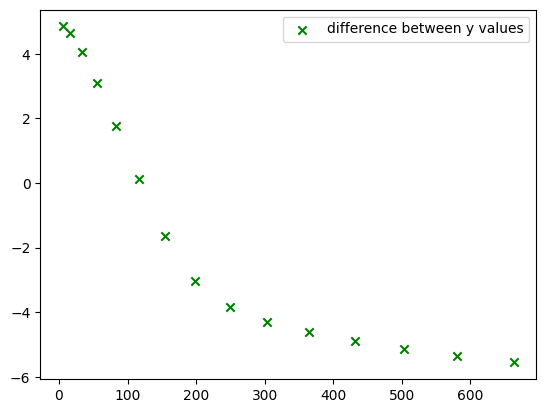

In [24]:
# calculate escape probability for each transition
beta = (1 - np.exp(-tauCo)) / tauCo
# Replace 0 with nan in beta
beta[beta == 0] = np.nan

# get the y axis of the plot: ln(γ_u * W / g_u * beta)
y_values = np.log(gammaCo * fluxCo_Jy / gCO * beta)

# calculate get y values using column density of the upper level
y_values_Nu = np.log(NuCo / gCO)
# calculate y values using column density of the upper level and beta
y_value_Nu_beta_consideration = np.log(NuCo / (beta * gCO))

diff_beta = y_values_Nu - y_values

# plot population diagram
fig, ax = plt.subplots()

# plot y values considering escape probaility
plt.scatter(EuCo, diff_beta, marker="x", color="green", label="difference between y values")
plt.legend()


$$\int T \, dv = \frac{I \cdot c^3}{2 k_B \nu^3}
$$

In [25]:
# use the above to convert from flux to Km/s (line intensity)
flux_kms = (fluxCo * constants.c**3) / (2 * nu0_arrayCo**3 * constants.k)

according to goldsmith and lander: $N_u =\gamma W /\beta $

where W is integrated line intensity

In [26]:
(gammaCo * int_line_intensity) / beta

array([3.94579325e+32, 5.03563609e+33, 1.47107952e+34, 2.11880662e+34,
       1.86006937e+34, 1.05756426e+34, 3.92907441e+33, 1.13790599e+33,
       3.00360854e+32, 6.90462693e+31, 1.31144414e+31, 2.02214448e+30,
       2.52793156e+29, 2.56914540e+28, 2.12902548e+27])

In [27]:
(gammaCo * flux_kms) / beta

array([2.10092108e+09, 3.35169622e+09, 2.90144382e+09, 1.76323909e+09,
       7.92672265e+08, 2.60866803e+08, 6.10477692e+07, 1.18477143e+07,
       2.19712624e+06, 3.68330015e+05, 5.25827059e+04, 6.24784927e+03,
       6.14617446e+02, 5.00378158e+01, 3.37319645e+00])

In [28]:
y_values / y_values_Nu

array([0.89915315, 0.90268969, 0.91376757, 0.93341426, 0.96145939,
       0.99754946, 1.03843153, 1.07318661, 1.09633505, 1.11293797,
       1.12810641, 1.14434917, 1.16298385, 1.18522026, 1.21271675])

## Not working population diagram 

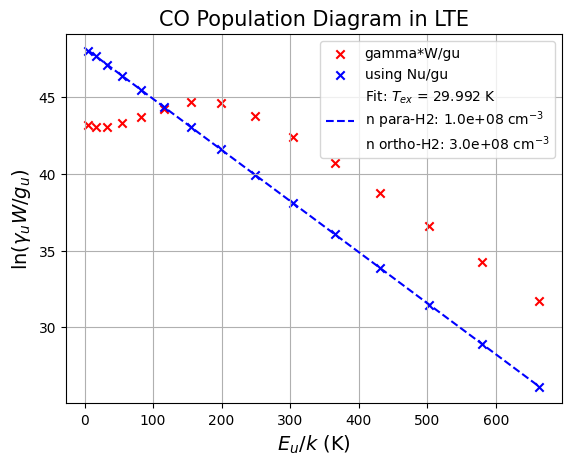

In [29]:
# plot population diagram
fig, ax = plt.subplots()
plt.scatter(EuCo, y_values, marker="x", color="red", label="gamma*W/gu")
plt.scatter(EuCo, y_values_Nu, marker="x", color="blue", label="using Nu/gu")

# plot y values considering escape probaility
# plt.scatter(EuCo, y_value_new_beta_consideration, marker="x", color="green", label="considering beta and Nu")


plt.xlabel(r"$E_u/k$ (K)", fontsize=14)
plt.ylabel(r"$\ln(\gamma_u W / g_u)$", fontsize=14)
plt.title("CO Population Diagram in LTE", fontsize=15)

# # Fit a straight line to estimate T_ex
fit = np.polyfit(EuCo, y_values_Nu, 1)  # Linear fit
T_ex = -1 / fit[0]  # Rotational temperature from slope

# Plot the best-fit line
x_fit = np.linspace(min(EuCo), max(EuCo), 100)
y_fit = fit[0] * x_fit + fit[1]
plt.plot(
    x_fit,
    y_fit,
    linestyle="--",
    color="blue",
    label=(f"Fit: $T_{{ex}}$ = {T_ex:.5g} K\nn para-H2: {para_h2_density:.1e} cm$^{{-3}}$\nn ortho-H2: {ortho_h2_density:.1e} cm$^{{-3}}$"),
)
plt.legend()
ax.grid()
plt.show()

### why the the two y values are some many order of difference ???

# Escape propability investigation
Escape probability for a homogeneous, static sphere is given by:

 
$$
\beta_{sphere}(\tau_\nu) = \frac{3}{2\tau_\nu} \left( 1 - \frac{2}{\tau_\nu^2} + \left( \frac{2}{\tau_\nu} + \frac{2}{\tau_\nu^2} \right) e^{-\tau_\nu} \right)
$$

$\tau_\nu$ is the optical depth.
Escape probability for expanding spherical shell, appriximation know as the large
velocity gradient (LVG) approximation:

$$ \beta_{slab}(\tau) = \frac{1 - e^{-\tau}}{\tau}$$



Escape probability of a homogeneous slab with a constant velocity gradient: 
$$\beta_{slab}(\tau) = \frac{1 - e^{-3\tau}}{3\tau}
 $$
Escape probability used by RADEX of a LVG sphere:
 $$\beta(\tau) = \frac{1}{\tau_\nu \sqrt{\ln(\tau_\nu / (2\sqrt{\pi}))}} \quad \text{if } \tau_\nu > 7
 $$

 $$\beta(\tau) = \frac{4 - 4e^{-2.34\tau_\nu / 2}}{4.68\tau_\nu} \quad \text{if } \tau_\nu < 7
$$

Equation for the population diagram taking into acount optical depth is: 
$$
ln{\frac{\gamma_u W}{g_u \beta}}=ln{N/Z}-\frac{E_u}{kT}
$$

C:\Users\alios\AppData\Local\Temp\ipykernel_36760\3588059773.py:33: RuntimeWarning: invalid value encountered in sqrt
  1 / (tau_nu * np.sqrt(np.log(tau_nu / (2 * np.sqrt(np.pi))))),
C:\Users\alios\AppData\Local\Temp\ipykernel_36760\3588059773.py:47: RuntimeWarning: invalid value encountered in sqrt
  1 / (tau_nu * np.sqrt(np.log(tau_nu / (np.sqrt(np.pi))))),


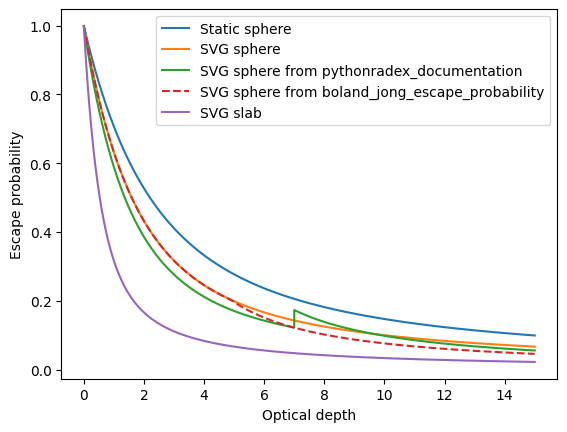

In [ ]:
# different ways to calculate the escape probability
def beta_sphere(tau_nu):
    """Calculate the escape probability for homogeneous, static sphere"""
    tau_nu = np.where(tau_nu == 0, np.nan, tau_nu)  # Avoid division by zero
    return (1.5 / (tau_nu)) * (1 - (2 / tau_nu**2) + ((2 / tau_nu) + (2 / tau_nu**2)) * np.exp(-tau_nu))


def svg_escape_probability(tau_nu):
    """Calculate the escape probability for an expanding sphere"""
    tau_nu = np.where(tau_nu == 0, np.nan, tau_nu)
    return (1 - np.exp(-tau_nu)) / tau_nu


def beta_slab(tau_nu):
    """Calculate the escape probability for a slab in the large velocity gradient approximation (LVG)"""
    tau_nu = np.where(tau_nu == 0, np.nan, tau_nu)
    return (1 - np.exp(-3 * tau_nu)) / (3 * tau_nu)


def beta_pythonradex_documentation(tau_nu):
    """
    Calculate the escape probability based on RADEX documentation.

    Parameters:
    tau_nu (float or np.array): Optical depth tau_nu.

    Returns:
    float or np.array: Computed beta(tau_nu).
    """
    tau_nu = np.where(tau_nu == 0, np.nan, tau_nu)
    beta = np.where(
        tau_nu >= 7,
        1 / (tau_nu * np.sqrt(np.log(tau_nu / (2 * np.sqrt(np.pi))))),
        (4 - 4 * np.exp(-2.34 * tau_nu / 2)) / (4.68 * tau_nu),
    )
    return beta


def boland_jong_escape_probability(tau_nu):
    """
    Compute escape probability based on equation given in appendix A.
    """
    tau_nu = np.where(tau_nu == 0, np.nan, tau_nu)
    beta = np.where(
        tau_nu < 4.9,
        (1 - np.exp(-tau_nu)) / tau_nu,
        1 / (tau_nu * np.sqrt(np.log(tau_nu / (np.sqrt(np.pi))))),
    )
    return beta


tau_array = np.linspace(0, 15, int(1e4))
beta_sphere_array = beta_sphere(tau_array)
svg_escape_probability_array = svg_escape_probability(tau_array)
beta_slab_array = beta_slab(tau_array)
tau_pythonradex_documentation_array = beta_pythonradex_documentation(tau_array)
boland_jong_escape_probability_array = boland_jong_escape_probability(tau_array)

# plot the escape probability
plt.plot(tau_array, beta_sphere_array, label="Static sphere")
plt.plot(tau_array, svg_escape_probability_array, label="SVG sphere")

plt.plot(tau_array, tau_pythonradex_documentation_array, label="SVG sphere from pythonradex_documentation")
plt.plot(tau_array, boland_jong_escape_probability_array, "--", label="SVG sphere from boland_jong_escape_probability")
plt.plot(tau_array, beta_slab_array, label="SVG slab")


plt.xlabel("Optical depth")
plt.ylabel("Escape probability")
plt.legend()
plt.show()

## Plot population diagram values without taking in consideration escepate probability 
PythonRADEX computes fractional population column densities while accounting for escape probabilities based on the selected geometry. To investigate the significance of including photon escape probability from the cloud, I removed the beta corrections from Nu by multiplying the escape probability for transitions with optical depths greater than a specified threshold (to avoid infinities).

In [97]:
def calculate_y_values_nobeta(Nu, gu, tau, beta_function, debug=False):
    """
    Calculate y values for the population diagram without beta correction.

    Parameters
    -----------
    Nu (numpy.ndarray):
        Upper level population density.
    gu (numpy.ndarray):
        Statistical weight of the upper level.
    tau (numpy.ndarray):
        Optical depth of the transitions.
    beta_function (function):
        Function to calculate the escape probability, possible functions are: beta_sphere, svg_escape_probability, beta_slab, beta_pythonradex_documentation, boland_jong_escape_probability.
    debug (boolean, optional):
        If True, print debugging information. Default is False.

    Returns
    --------
    y_values_without_beta (numpy.ndarray): y values without beta correction.
    """
    # Calculate escape probability for each transition
    beta = beta_function(tau)

    # Create a mask for tau values greater than 1e-3, returns a boolean array
    mask_tau = tau > 1e-3

    # remove beta correction only for values where tau > 1e-3
    y_values_nobeta = np.log(Nu / gu)
    y_values_nobeta[mask_tau] = np.log((Nu[mask_tau] * beta[mask_tau]) / gu[mask_tau])

    # section for debugging
    if debug:
        print("tau values:", tau)
        print("Escape probability values:", beta)
        print("Positions where tau is greater than threshold:", mask_tau)
        print("y values without escape probability taken into account:", y_values_nobeta)
    return y_values_nobeta


In [98]:
y_values_LTE_noBETA = calculate_y_values_nobeta(NuCo, gCO, tauCo, beta_sphere)

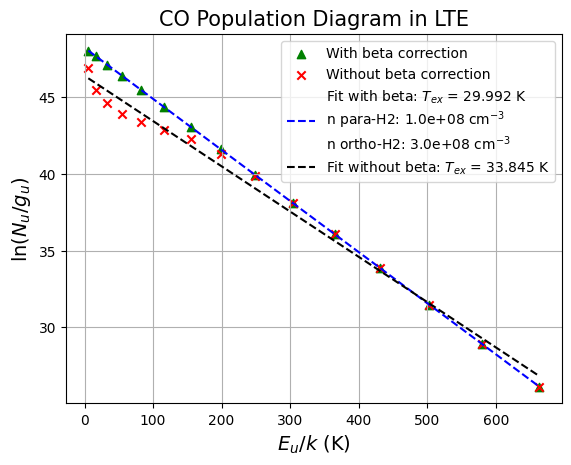

In [99]:
# plot population diagram
fig, ax = plt.subplots()
plt.scatter(
    EuCo,
    np.log(NuCo / gCO),
    marker="^",
    color="green",
    label="With beta correction",
)
plt.scatter(
    EuCo,
    y_values_LTE_noBETA,
    marker="x",
    color="red",
    label="Without beta correction",
)
plt.xlabel(r"$E_u/k$ (K)", fontsize=14)
plt.ylabel(r"$\ln(N_u/ g_u)$", fontsize=14)
plt.title("CO Population Diagram in LTE", fontsize=15)

# Fit a straight line to estimate T_ex with beta correction
fit_beta = np.polyfit(EuCo, np.log(NuCo / gCO), 1)
Tex_beta = -1 / fit_beta[0]  # Rotational temperature from slope


# Fit a straight line to estimate T_ex without beta correction
fit_no_beta = np.polyfit(EuCo, y_values_LTE_noBETA, 1)
Tex_no_beta = -1 / fit_no_beta[0]  # Rotational temperature from slope


# Plot the best-fit line with beta correction
x_fit_LTE = np.linspace(min(EuCo), max(EuCo), 100)
y_fit_LTE = fit_beta[0] * x_fit_LTE + fit_beta[1]

# Plot the best-fit line without beta correction
y_fit_no_beta = fit_no_beta[0] * x_fit_LTE + fit_no_beta[1]

plt.plot(
    x_fit_LTE,
    y_fit_LTE,
    linestyle="--",
    color="blue",
    label=(
        f"Fit with beta: $T_{{ex}}$ = {Tex_beta:.5g} K\nn para-H2: {para_h2_density:.1e} cm$^{{-3}}$\nn ortho-H2: {ortho_h2_density:.1e} cm$^{{-3}}$"
    ),
)

plt.plot(
    x_fit_LTE,
    y_fit_no_beta,
    linestyle="--",
    color="black",
    label=(f"Fit without beta: $T_{{ex}}$ = {Tex_no_beta:.5g} K"),
)

plt.legend()
ax.grid()
plt.show()

In [100]:
print(f"Excitation temperature with escape probability correction: {Tex_beta:.5g} K")
print(f"Excitation temperature without escape probability correction: {Tex_no_beta:.5g} K")
print(f"kinetic temperature of the nebula: {Tkin} K")  # kinetic temperature in K)

Excitation temperature with escape probability correction: 29.992 K
Excitation temperature without escape probability correction: 33.845 K
kinetic temperature of the nebula: 30 K


As expected in LTE:
$$T_{ex} = T_{kin}$$

# Line profile of CO, LTE case
Spectrum function finds flux density in $W/m^2 Hz$, notice this is just $J/m^2$

fluxes_of_individual_transitions finds flux in $W/m^2$

## Gaussian and total gaussian functions

In [101]:
def gaussian(x, amp, cen, fwhm):
    """
    Gaussian function.

    Parameters:
        x: array-like, the independent variable (e.g., wavelength)
        amp: float, the amplitude of the Gaussian
        cen: float, the center of the Gaussian
        fwhm: float, the full width at half maximum of the Gaussian

    Returns:
        The Gaussian evaluated at x.
    """
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    return amp * np.exp(-((x - cen) ** 2) / (2 * sigma**2))


# Define the model: a sum of Gaussians.
def model_spectrum(x, params):
    """
    Create spectrum, sum of Gaussians.

    Parameters:
        x: array-like, the independent variable (e.g., frequency)
        params: list or array of parameters. For n Gaussians, params should be of length 3*n,
                where each Gaussian has [amp, cen, fwhm] in order.

    Returns:
        The sum of Gaussians evaluated at x.
    """
    n_gauss = len(params) // 3
    total = np.zeros_like(x)
    for i in range(n_gauss):
        amplitude = params[3 * i]
        center = params[3 * i + 1]
        fwhm = params[3 * i + 2]
        # print(f"Transition {i}: amplitude={amplitude}, center={center}, width={fwhm}")

        total += gaussian(x, amplitude, center, fwhm)
    return total


## Spectrum using flux  

### Frequency space

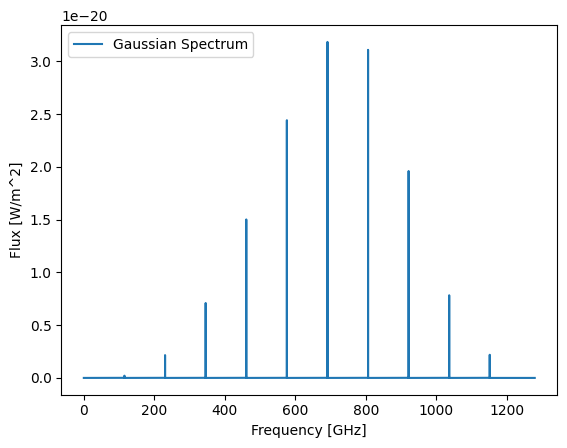

In [102]:
# number of transitions to plot in spectrum
n_trans_spectrum = 10

# generate frequancy space
x = np.linspace(0, nu0_arrayCo[n_trans_spectrum] * 1.01, int(1e7))
params = []
for i in range(n_trans_spectrum):
    params.extend([fluxCo[i], nu0_arrayCo[i], FWHMCO[i]])

# Generate the spectrum
spectrum = model_spectrum(x, params)

# Plot the spectrum
fig, ax = plt.subplots()
plt.plot(x / constants.giga, spectrum, label="Gaussian Spectrum")
plt.xlabel("Frequency [GHz]")
plt.ylabel(r"Flux [W/m^2]")
plt.legend()
plt.show()

#### Spectrum in frequency space using Stem plot 

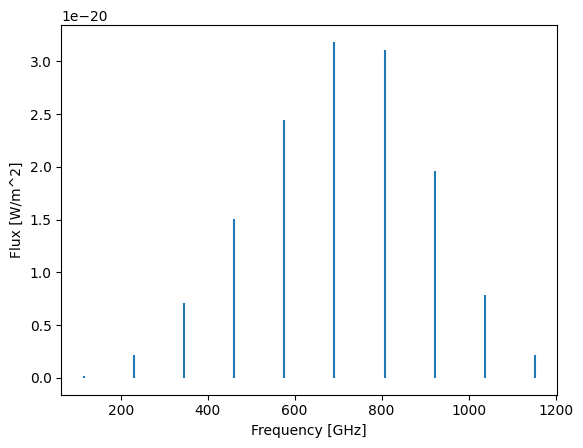

In [103]:
# plot the spectrum with individual fluxes
plt.stem(nu0_arrayCo[:n_trans_spectrum] / constants.giga, fluxCo[:n_trans_spectrum], basefmt=" ", markerfmt=" ")

# to plot as a gaussina curve
# plt.plot(array_nu0 / constants.giga, flux, drawstyle="steps-mid")

plt.xlabel("Frequency [GHz]")
plt.ylabel("Flux [W/m^2]")
plt.show()

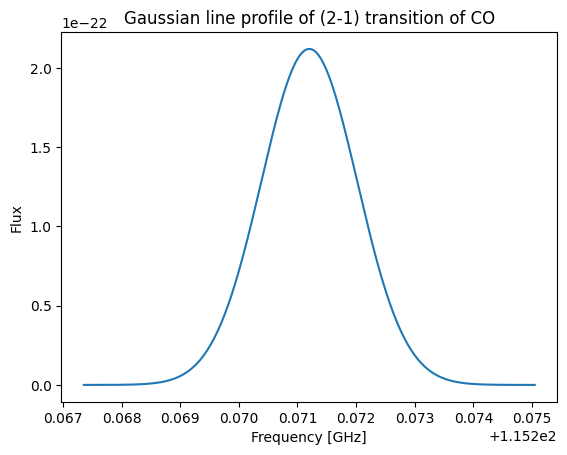

In [104]:
# FWHMCO of first transition
first_fwhm = FWHMCO[0]
x = np.linspace(nu0_arrayCo[0] - 2 * first_fwhm, nu0_arrayCo[0] + 2 * first_fwhm, int(1e7))
params = []
for i in range(NUM_TRANSITIONS):
    params.extend([fluxCo[i], nu0_arrayCo[i], FWHMCO[i]])


# Generate the spectrum
single_spectrum = model_spectrum(x, params)

# plot frequency vs flux
fig, ax = plt.subplots()
plt.title("Gaussian line profile of (2-1) transition of CO")
plt.plot(x / constants.giga, single_spectrum)
plt.xlabel("Frequency [GHz]")
plt.ylabel("Flux")
plt.show()

### Spectrum with arbitrary large FWHM

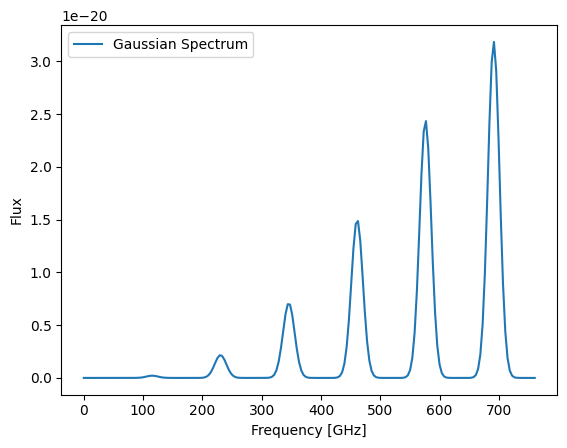

In [105]:
#  arbitrary fwhm
fwhm_frequancy = nu0_arrayCo[1] * 0.1

# Example usage
x = np.linspace(0, nu0_arrayCo[5] * 1.1, 200)
params = []
for i in range(NUM_TRANSITIONS):
    # fwhm_frequancy = nu0_arrayCo[i] * 0.1
    params.extend([fluxCo[i], nu0_arrayCo[i], fwhm_frequancy])

# Generate the spectrum
spectrum = model_spectrum(x, params)

# Plot the spectrum
fig, ax = plt.subplots()
plt.plot(x / constants.giga, spectrum, label="Gaussian Spectrum")
plt.xlabel("Frequency [GHz]")
plt.ylabel("Flux")
plt.legend()
plt.show()

### Velocity space

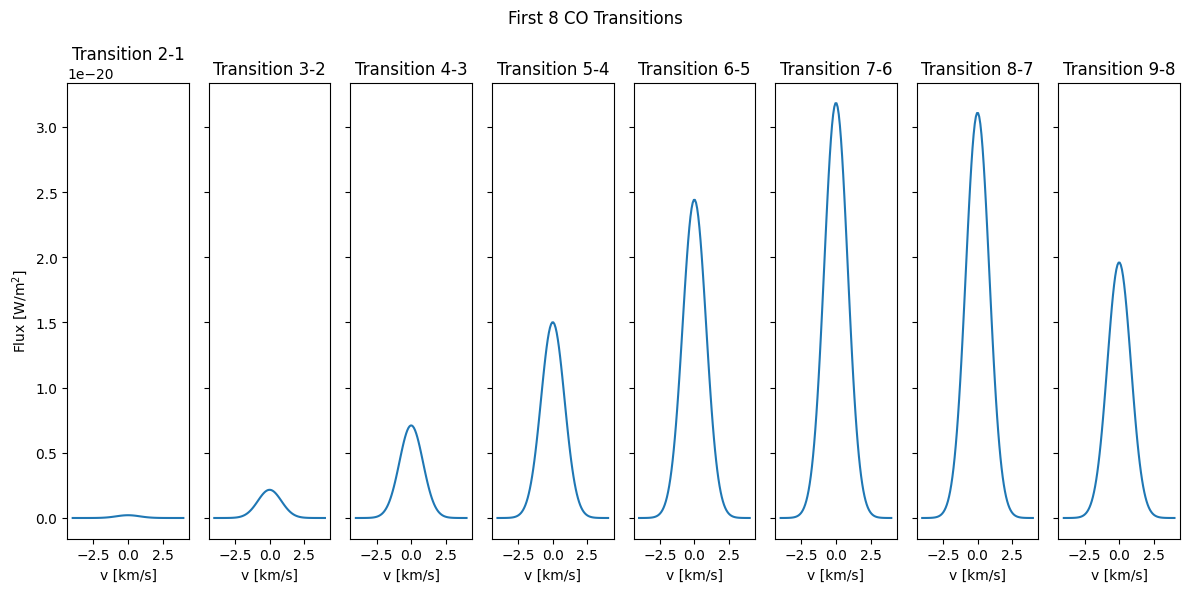

In [106]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(12, 6), sharey=True)
fig.suptitle("First 8 CO Transitions")

v = np.linspace(-2 * width_v, 2 * width_v, 100)  # Velocity range in m/s

for i in range(8):
    nu0 = nu0_arrayCo[i]  # Rest frequency of transition i
    nu = nu0 * (1 - v / constants.c)  # Convert frequency to velocity

    # Calculate Gaussian profile
    fwhm = nu0 * (width_v / constants.c)
    spectrum = gaussian(nu, fluxCo[i], nu0, fwhm)

    ax = axes[i]
    ax.plot(v / constants.kilo, spectrum)
    ax.set_title(f"Transition {i + 2}-{i + 1}")
    ax.set_xlabel("v [km/s]")
axes[0].set_ylabel(r"Flux [W/m$^2$]")

fig.tight_layout()
plt.show()

## Spectum in velocity space using flux density 

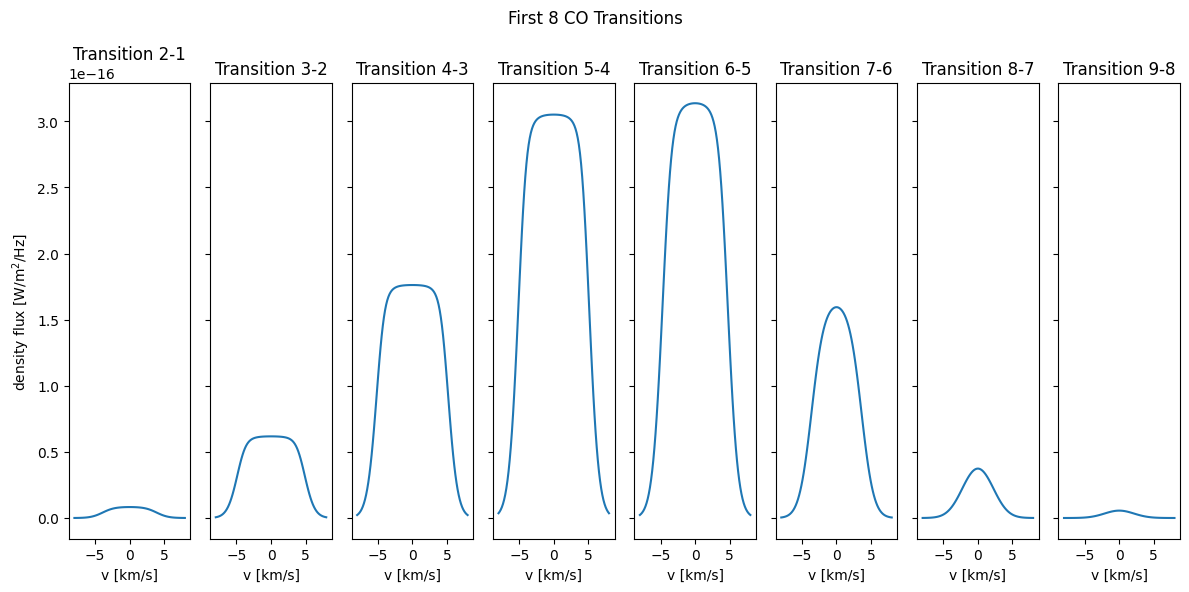

In [107]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(12, 6), sharey=True)
fig.suptitle("First 8 CO Transitions")

v = np.linspace(-4 * width_v, 4 * width_v, 100)  # Velocity range in m/s

for i in range(8):
    nu0 = nu0_arrayCo[i]  # Rest frequency of transition i
    nu = nu0 * (1 - v / constants.c)  # Convert frequency to velocity
    spectrum = cloud.spectrum(nu=nu, solid_angle=source_solid_angle)  # Compute spectrum, this give the flux density in W/m^2Hz

    ax = axes[i]
    ax.plot(v / constants.kilo, spectrum * nu)
    ax.set_title(f"Transition {i + 2}-{i + 1}")
    ax.set_xlabel("v [km/s]")
axes[0].set_ylabel(r"density flux [W/m$^2$/Hz]")

fig.tight_layout()
plt.show()

# CO for non-LTE case

## Update cloud

In [108]:
# update the claud using low densities of h2
# collider densities in cm-3:
para_h2_density_nonLTE = 1e3
ortho_h2_density_nonLTE = 3e3


collider_densities_nonLTE = {
    "para-H2": para_h2_density_nonLTE / constants.centi**3,
    "ortho-H2": ortho_h2_density_nonLTE / constants.centi**3,
}

cloud.update_parameters(
    N=N,
    Tkin=Tkin,
    collider_densities=collider_densities_nonLTE,
    ext_background=ext_background,
    T_dust=T_dust,
    tau_dust=tau_dust,
)

cloud.solve_radiative_transfer()

In [109]:
cloud.print_results()



  up   low      nu0 [GHz]    T_ex [K]      poplow         popup         tau_nu0
   1    0     115.271202      28.25       0.104638       0.258089         5.2882
   2    1     230.538000      27.54       0.258089       0.287849        16.1649
   3    2     345.795990      26.29       0.287849       0.214339        22.9474
   4    3     461.040768      23.11       0.214339       0.105777        21.3805
   5    4     576.267931      17.67       0.105777      0.0270289        13.1415
   6    5     691.473076      12.33      0.0270289     0.00216687        3.87678
   7    6     806.651806      12.17     0.00216687    0.000103892       0.314696
   8    7     921.799700      16.53    0.000103892    8.10188e-06      0.0144759
   9    8    1036.912393      18.53    8.10188e-06    6.17184e-07     0.00111745
  10    9    1151.985452      19.66    6.17184e-07    4.10105e-08    8.49826e-05
  11   10    1267.014486      20.31    4.10105e-08    2.24832e-09    5.65792e-06
  12   11    1381.995105   

## Plot spectrum lines, non-LTE case

In [110]:
# initialize the class with the new cloud object
CO_cloud_instance_nonLTE = MyClass(cloud, data_co, N, width_v, Tkin)
# get the values from the non-LtE cloud object and the data file

TexCo_nonLTE, tauCo_nonLTE, _, _, _, _, _, _, gammaCo_nonLTE, NuCo_nonLTE, NlCo_nonLTE, FWHMCO_nonLTE = (
    CO_cloud_instance_nonLTE.extract_and_calculate(debug=False)
)


# Slice all the arrays to get only the first NUM_TRANSITIONS transitions
TexCo_nonLTE = TexCo_nonLTE[:NUM_TRANSITIONS]
tauCo_nonLTE = tauCo_nonLTE[:NUM_TRANSITIONS]
gammaCo_nonLTE = gammaCo_nonLTE[:NUM_TRANSITIONS]
NuCo_nonLTE = NuCo_nonLTE[:NUM_TRANSITIONS]
NlCo_nonLTE = NlCo_nonLTE[:NUM_TRANSITIONS]


In [111]:
# calculate the observed fluxes [W/m2], outputed as a list
flux_nonLTE = cloud.fluxes_of_individual_transitions(transitions=None, solid_angle=source_solid_angle)

# convert flux to np.array
flux_nonLTE = np.array(flux_nonLTE)

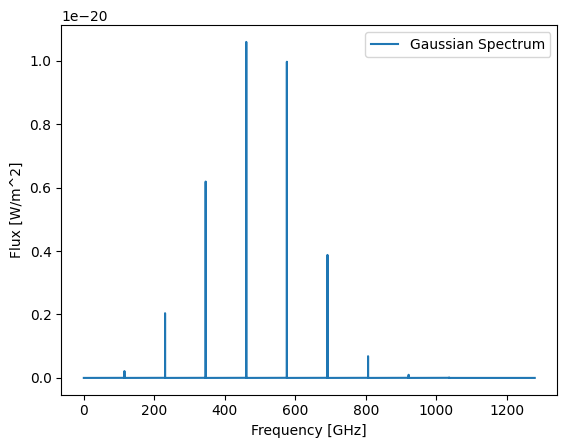

In [112]:
# number of transitions to plot in spectrum
n_trans_spectrum = 10

# generate frequancy space
x = np.linspace(0, nu0_arrayCo[n_trans_spectrum] * 1.01, int(1e7))
params = []
for i in range(n_trans_spectrum):
    params.extend([flux_nonLTE[i], nu0_arrayCo[i], FWHMCO[i]])

# Generate the spectrum
spectrum = model_spectrum(x, params)

# Plot the spectrum
fig, ax = plt.subplots()
plt.plot(x / constants.giga, spectrum, label="Gaussian Spectrum")
plt.xlabel("Frequency [GHz]")
plt.ylabel(r"Flux [W/m^2]")
plt.legend()
plt.show()

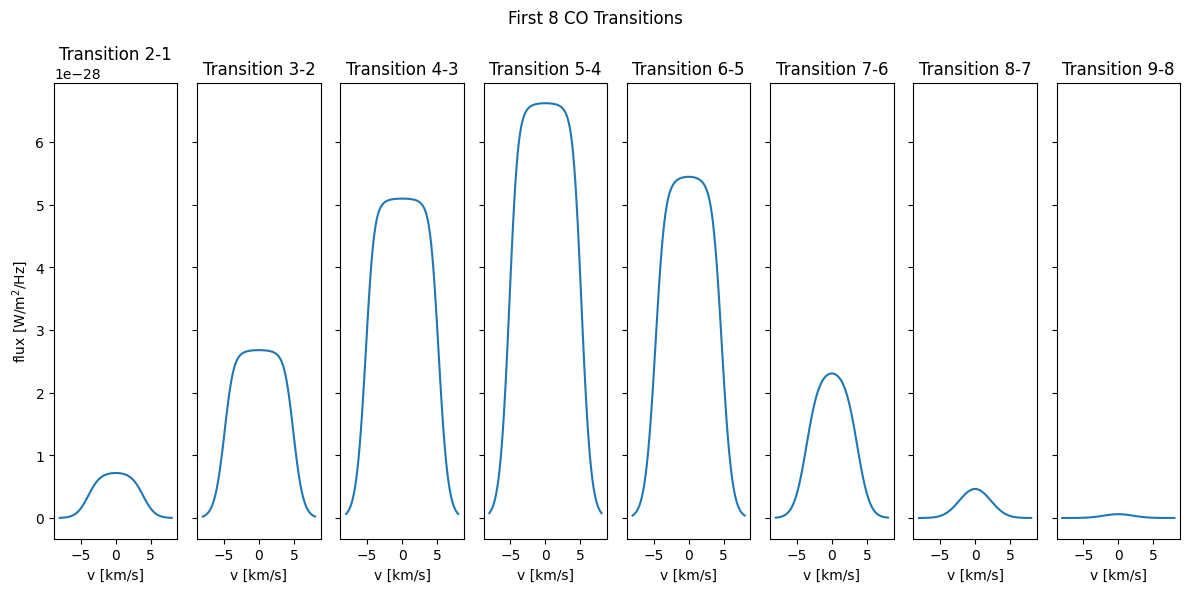

In [113]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(12, 6), sharey=True)
fig.suptitle("First 8 CO Transitions")

v = np.linspace(-4 * width_v, 4 * width_v, 100)  # Velocity range in m/s

for i in range(8):
    nu0 = nu0_arrayCo[i]  # Rest frequency of transition i
    nu = nu0 * (1 - v / constants.c)  # Convert frequency to velocity
    spectrum = cloud.spectrum(nu=nu, solid_angle=source_solid_angle)  # Compute spectrum

    ax = axes[i]  # Select subplot in 2x4 grid
    ax.plot(v / constants.kilo, spectrum)
    ax.set_title(f"Transition {i + 2}-{i + 1}")
    ax.set_xlabel("v [km/s]")
axes[0].set_ylabel(r"flux [W/m$^2$/Hz]")

fig.tight_layout()
plt.show()

## Plot CO population diagram, non-LTE case

### REMOVE the below, wrong beta corrections

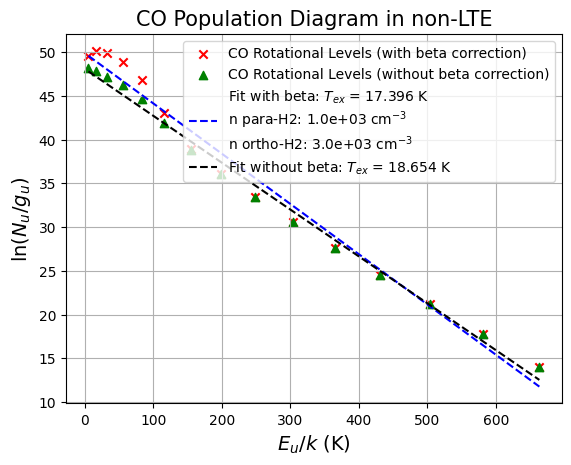

In [114]:
# calculate escape probability for each transition
beta_nonLTE = beta_sphere(tauCo_nonLTE)

# create a mask for tau_co_nonLTE values greater than 0.1, returns a boolean array
mask_tau = tauCo_nonLTE > 0.1

# initialize y_values_nonLTE with the values without beta correction
y_values_nonLTE = np.log(NuCo_nonLTE / gCO)

# apply beta correction only for values where tau_co_nonLTE > 0.1
y_values_nonLTE[mask_tau] = np.log(NuCo_nonLTE[mask_tau] / (gCO[mask_tau] * beta_nonLTE[mask_tau]))

# plot population diagram
fig, ax = plt.subplots()
plt.scatter(EuCo, y_values_nonLTE, marker="x", color="red", label="CO Rotational Levels (with beta correction)")
plt.scatter(EuCo, np.log(NuCo_nonLTE / gCO), marker="^", color="green", label="CO Rotational Levels (without beta correction)")
plt.xlabel(r"$E_u/k$ (K)", fontsize=14)
plt.ylabel(r"$\ln(N_u/ g_u)$", fontsize=14)
plt.title("CO Population Diagram in non-LTE", fontsize=15)

# Fit a straight line to estimate T_ex with beta correction
fit = np.polyfit(EuCo, y_values_nonLTE, 1)  # Linear fit
T_ex_nonLTE = -1 / fit[0]  # Rotational temperature from slope

# Fit a straight line to estimate T_ex without beta correction
fit_no_beta = np.polyfit(EuCo, np.log(NuCo_nonLTE / gCO), 1)  # Linear fit
T_ex_nonLTE_no_beta = -1 / fit_no_beta[0]  # Rotational temperature from slope

# Plot the best-fit line with beta correction
x_fit = np.linspace(min(EuCo), max(EuCo), 100)
y_fit = fit[0] * x_fit + fit[1]
plt.plot(
    x_fit,
    y_fit,
    linestyle="--",
    color="blue",
    label=(
        f"Fit with beta: $T_{{ex}}$ = {T_ex_nonLTE:.5g} K\nn para-H2: {para_h2_density_nonLTE:.1e} cm$^{{-3}}$\nn ortho-H2: {ortho_h2_density_nonLTE:.1e} cm$^{{-3}}$"
    ),
)

# Plot the best-fit line without beta correction
y_fit_no_beta = fit_no_beta[0] * x_fit + fit_no_beta[1]
plt.plot(
    x_fit,
    y_fit_no_beta,
    linestyle="--",
    color="black",
    label=(f"Fit without beta: $T_{{ex}}$ = {T_ex_nonLTE_no_beta:.5g} K"),
)

plt.legend()
ax.grid()
plt.show()

In [118]:
# compute y values without beta correction
y_values_without_beta_nonLTE = calculate_y_values_nobeta(NuCo_nonLTE, gCO, tauCo_nonLTE, beta_sphere, debug=True)

tau values: [5.28820446e+00 1.61649123e+01 2.29474331e+01 2.13805493e+01
 1.31415024e+01 3.87677537e+00 3.14695645e-01 1.44759154e-02
 1.11745430e-03 8.49825915e-05 5.65792274e-06 3.09326859e-07
 1.47702564e-08 6.01820698e-10 2.03951627e-11]
Escape probability values: [0.26400844 0.09208334 0.06511852 0.06985028 0.11282037 0.34063322
 0.89127667 0.99459242 0.99958096 1.0005111  0.         0.
 0.         0.         0.        ]
Positions where tau is greater than threshold: [ True  True  True  True  True  True  True  True  True False False False
 False False False]
y values without escape probability taken into account: [46.87203374 45.41705218 44.43921741 43.55182765 42.46617001 40.88050254
 38.66156564 36.09482142 33.41391502 30.60291069 27.6082952  24.48525623
 21.20964372 17.75509801 14.05594705]


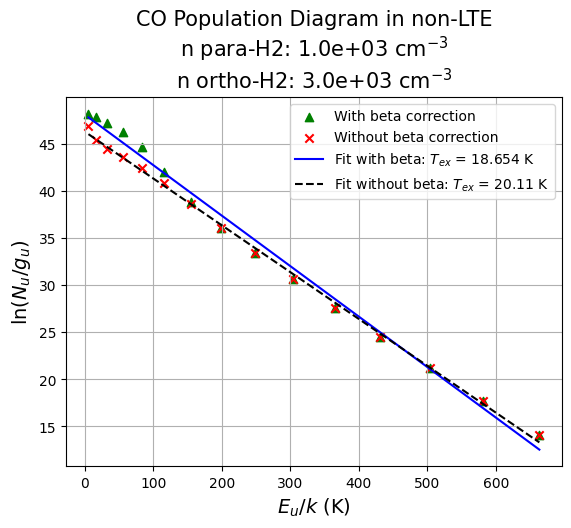

In [133]:
# plot population diagram
fig, ax = plt.subplots()
plt.scatter(
    EuCo,
    np.log(NuCo_nonLTE / gCO),
    marker="^",
    color="green",
    label="With beta correction",
)
plt.scatter(
    EuCo,
    y_values_without_beta_nonLTE,
    marker="x",
    color="red",
    label="Without beta correction",
)
plt.xlabel(r"$E_u/k$ (K)", fontsize=14)
plt.ylabel(r"$\ln(N_u/ g_u)$", fontsize=14)
plt.title(
    f"CO Population Diagram in non-LTE\nn para-H2: {para_h2_density_nonLTE:.1e} cm$^{{-3}}$\nn ortho-H2: {ortho_h2_density_nonLTE:.1e} cm$^{{-3}}$",
    fontsize=15,
)

# Fit a straight line to estimate T_ex with beta correction
fit_beta = np.polyfit(EuCo, np.log(NuCo_nonLTE / gCO), 1)
Tex_beta = -1 / fit_beta[0]  # Rotational temperature from slope

# Fit a straight line to estimate T_ex without beta correction
fit_no_beta = np.polyfit(EuCo, y_values_without_beta_nonLTE, 1)
Tex_no_beta = -1 / fit_no_beta[0]  # Rotational temperature from slope

# Plot the best-fit line with beta correction
x_fit_nonLTE = np.linspace(min(EuCo), max(EuCo), 100)
y_fit_nonLTE = fit_beta[0] * x_fit_nonLTE + fit_beta[1]

# Plot the best-fit line without beta correction
y_fit_no_beta = fit_no_beta[0] * x_fit_nonLTE + fit_no_beta[1]

plt.plot(
    x_fit_nonLTE,
    y_fit_nonLTE,
    linestyle="-",
    color="blue",
    label=(f"Fit with beta: $T_{{ex}}$ = {Tex_beta:.5g} K"),
)

plt.plot(
    x_fit_nonLTE,
    y_fit_no_beta,
    linestyle="--",
    color="black",
    label=(f"Fit without beta: $T_{{ex}}$ = {Tex_no_beta:.5g} K"),
)

plt.legend()
ax.grid()
plt.show()


In [121]:
print(f"Excitation temperature: {T_ex_nonLTE:.5g} K")
print(f"Excitation temperature without beta correction: {T_ex_nonLTE_no_beta:.5g} K")
print(f"Kinetic temperature of the cloud: {Tkin} K")  # kinetic temperature in K)

Excitation temperature: 17.396 K
Excitation temperature without beta correction: 18.654 K
Kinetic temperature of the cloud: 30 K


# plot population diagram using equation for non-LTE (probably made up), not sure if it is used correctly 

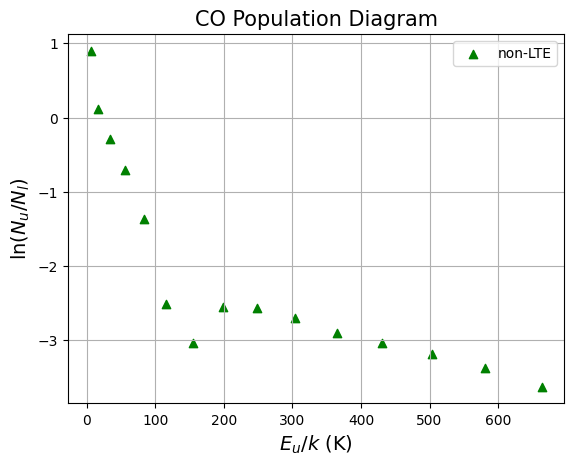

In [122]:
# plot log(Nu/Nl) vs Eu/k
fig, ax = plt.subplots()
# plt.scatter(EuCo, np.log(NuCo / NlCo), marker="x", color="red", label="LTE")
plt.scatter(EuCo, np.log(NuCo_nonLTE / NlCo_nonLTE), marker="^", color="green", label="non-LTE")
plt.xlabel(r"$E_u/k$ (K)", fontsize=14)
plt.ylabel(r"$\ln(N_u/N_l)$", fontsize=14)
plt.title("CO Population Diagram", fontsize=15)
plt.legend()
ax.grid()
plt.show()

# Plot population diagram for CH3OH-e

In [123]:
# pyhonradex needs a file containing the atomic data, import it, this is a specific file for CH3OH from LAMBDA database
datafilepath_methanol = (
    r"C:\Users\alios\OneDrive - University College London\Desktop\UCL\Year3\group project\codes\e_ch3oh.dat"  # file downloaded from LAMDA database
)

# store the data
data_methanol = LAMDA_file.read(datafilepath_methanol, read_frequencies=False)

# define the geometry of the nebula
geometry = "uniform sphere"

# define the parameters of the nebula
Ntot_emeth = 1e16 / constants.centi**3  # total column density in m^-2
line_profile_type = "Gaussian"  # line profile, can be "rectangular" or "Gaussian"
width_v = 2 * constants.kilo  # line width in m/s, costants.kilo is 1 km/s

cloud_metahnol = radiative_transfer.Cloud(
    datafilepath=datafilepath_methanol,
    geometry=geometry,
    line_profile_type=line_profile_type,
    width_v=width_v,
)

N = 1e18 / constants.centi**2  # CH3OH_e column density in m-2

# collider densities in m-3, for ch3oh-e ther is only one input parameter, hence no distinction between para- an otho-H2
LTE_collider_densities_h2only = {"H2": 1e8 / constants.centi**3}

# define the background radiation field, in this case we assume that the background is zero, z is the redshift
ext_background = helpers.generate_CMB_background(z=0)

# no dust:
T_dust = 0
tau_dust = 0

# use high colliders density to simulate LTE
cloud_metahnol.update_parameters(
    N=N,
    Tkin=Tkin,
    collider_densities=LTE_collider_densities_h2only,
    ext_background=ext_background,
    T_dust=T_dust,
    tau_dust=tau_dust,
)

# solve the radiative trasfer, i.e. calculate the level population with an iterative method
cloud_metahnol.solve_radiative_transfer()

79-78: tau_nu0 = -0.00803


c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\radiative_transfer.py:110: UserWarning: some lines are overlapping, but treatement of overlapping lines not activated
  warnings.warn('some lines are overlapping, but treatement of'
c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\radiative_transfer.py:333: UserWarning: negative optical depth!
  warnings.warn('negative optical depth!')


In [124]:
cloud_metahnol.print_results()



  up   low      nu0 [GHz]    T_ex [K]      poplow         popup         tau_nu0
  79   78       2.937966    -115.09    0.000776267     0.00085124    -0.00803479
  14   13       3.387655      25.57      0.0268868      0.0343496    4.52063e-05
  96   95       7.284957      10.00    0.000200854    0.000212422      0.0460138
  30   28       9.413483      28.61      0.0183335      0.0156401     0.00166136
  46   45       9.923130      35.44     0.00566386     0.00624569       0.726678
   5    4      12.171574      27.87      0.0468881      0.0327968        16.1951
 132  131      14.899685      10.94    2.23633e-05    1.95965e-05     0.00017176
  28   27      15.619187      33.06      0.0162534      0.0183335    0.000311707
  58   56      18.347298      29.45     0.00315312     0.00273812    0.000196216
   8    7      19.966178      29.76      0.0364038      0.0251787        8.93201
  42   40      22.304559      23.51     0.00668561     0.00540522    1.08199e-11
  78   77      23.383812   

In [125]:
# extract the data from the cloud object and the data file
CH3OH_instance = MyClass(cloud_metahnol, data_methanol, N, width_v, Tkin)

TexCH3OH, tauCH3OH, AulCH3OH, BulCH3OH, nu0_arrayCH3OH, EuCH3OH, gCH3OH, glow_CH3OH, gammaCH3OH, NuCH3OH, NlCH3OH, FWHMCH3OH = (
    CH3OH_instance.extract_and_calculate(debug=True)
)

# calculate the optical depth of a transition using the different approaches
tau_radex_CH3OH, tau_pythonRADEX_approx_CH3OH = CH3OH_instance.optical_depth()

Size of nu0_array: 2324
Size of Eu: 2324
E upper levels: [ 175.52646272   36.33487126  215.89566435 ...  788.06989178  972.79157753
 1405.59868271]
Size of gu: 2324
size exitation temperature Tex: 2324
 gu: [23.  9. 23. ... 31. 29. 31.]
Size of glow: 2324
 glow: [21.  7. 21. ... 29. 31. 31.]
size Aul: 2324
size FWHM_each_transition: 2324
size gamma: 2324
size Nu: 2324
size Nl: 2324


In [126]:
# calculate get y values using column density of the upper level
y_values_metanol = np.log(NuCH3OH / gCH3OH)

<>:27: SyntaxWarning: invalid escape sequence '\c'
<>:27: SyntaxWarning: invalid escape sequence '\c'
C:\Users\alios\AppData\Local\Temp\ipykernel_36760\2852518622.py:27: SyntaxWarning: invalid escape sequence '\c'
  f"$\chi^2$ = {chi_squared:.2f}\n"


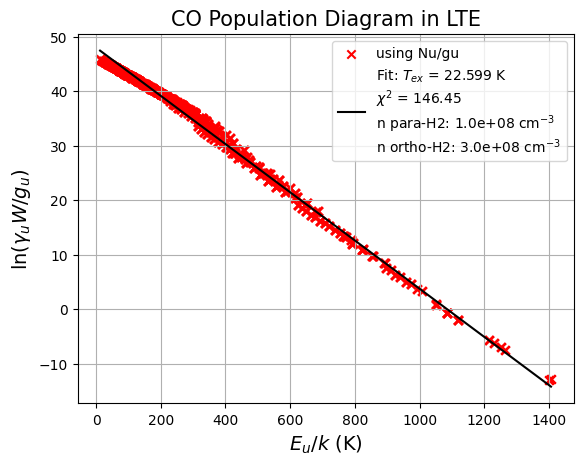

In [127]:
# plot population diagram
fig, ax = plt.subplots()
plt.scatter(EuCH3OH, y_values_metanol, marker="x", color="red", label="using Nu/gu")

plt.xlabel(r"$E_u/k$ (K)", fontsize=14)
plt.ylabel(r"$\ln(\gamma_u W / g_u)$", fontsize=14)
plt.title("CO Population Diagram in LTE", fontsize=15)

# Fit a straight line to estimate T_ex
fit = np.polyfit(EuCH3OH, y_values_metanol, 1)  # Linear fit
T_ex = -1 / fit[0]  # Rotational temperature from slope

# Calculate the chi-squared value
y_fit = fit[0] * EuCH3OH + fit[1]
chi_squared = np.sum(((y_values_metanol - y_fit) ** 2) / y_fit)

# Plot the best-fit line
x_fit = np.linspace(min(EuCH3OH), max(EuCH3OH), 100)
y_fit_line = fit[0] * x_fit + fit[1]
plt.plot(
    x_fit,
    y_fit_line,
    linestyle="-",
    color="black",
    label=(
        f"Fit: $T_{{ex}}$ = {T_ex:.5g} K\n"
        f"$\chi^2$ = {chi_squared:.2f}\n"
        f"n para-H2: {para_h2_density:.1e} cm$^{{-3}}$\n"
        f"n ortho-H2: {ortho_h2_density:.1e} cm$^{{-3}}$"
    ),
)
plt.legend()
ax.grid()
plt.show()

<>:36: SyntaxWarning: invalid escape sequence '\c'
<>:36: SyntaxWarning: invalid escape sequence '\c'
C:\Users\alios\AppData\Local\Temp\ipykernel_36760\3187932018.py:36: SyntaxWarning: invalid escape sequence '\c'
  label=(f"Fit: $T_{{ex}}$ = {T_ex:.5g} K\n$\chi^2$ = {chi_squared:.5g}"),


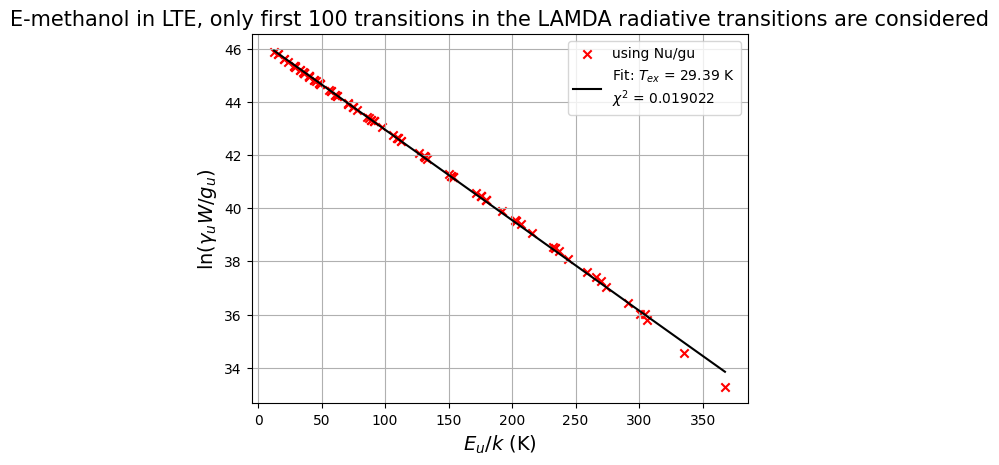

In [128]:
# Take only N first transitions
firstN_transitions = 100

# calculate get y values using column density of the upper level
y_values_metanol = np.log(NuCH3OH[:firstN_transitions] / gCH3OH[:firstN_transitions])

# plot population diagram
fig, ax = plt.subplots()
plt.scatter(EuCH3OH[:firstN_transitions], y_values_metanol, marker="x", color="red", label="using Nu/gu")

# plot y values considering escape probaility
# plt.scatter(EuCo, y_value_new_beta_consideration, marker="x", color="green", label="considering beta and Nu")

plt.xlabel(r"$E_u/k$ (K)", fontsize=14)
plt.ylabel(r"$\ln(\gamma_u W / g_u)$", fontsize=14)
plt.title(f"E-methanol in LTE, only first {firstN_transitions} transitions in the LAMDA radiative transitions are considered", fontsize=15)

# Fit a straight line to estimate T_ex
fit = np.polyfit(EuCH3OH[:firstN_transitions], y_values_metanol, 1)  # Linear fit
T_ex = -1 / fit[0]  # Rotational temperature from slope

# Calculate the fitted y-values
x_fit = np.linspace(min(EuCH3OH[:firstN_transitions]), max(EuCH3OH[:firstN_transitions]), 100)
y_fit = fit[0] * x_fit + fit[1]

# Calculate chi-squared
y_fit_observed = fit[0] * EuCH3OH[:firstN_transitions] + fit[1]
chi_squared = np.sum(((y_values_metanol - y_fit_observed) ** 2) / y_fit_observed)

# Plot the best-fit line
plt.plot(
    x_fit,
    y_fit,
    linestyle="-",
    color="black",
    label=(f"Fit: $T_{{ex}}$ = {T_ex:.5g} K\n$\chi^2$ = {chi_squared:.5g}"),
)
plt.legend()
ax.grid()
plt.show()
